In [ ]:
!cd '/content/drive/MyDrive/CAMS Dataset'

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModel
import sys
import csv
import re
import string
import pickle
from collections import defaultdict
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import nltk
from transformers import AdamW
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
model = AutoModel.from_pretrained("mental/mental-bert-base-uncased")

Some weights of the model checkpoint at mental/mental-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert

In [ ]:
##file paths
PTH_TRAIN = '/content/drive/MyDrive/CAMS Dataset/IntentSDCNL_Training.csv'
PTH_TEST = '/content/drive/MyDrive/CAMS Dataset/IntentSDCNL_Testing.csv'
CAMS_DATASET = '/content/drive/MyDrive/CAMS Dataset/added_CAMS_data.csv'

## Encoding Variable ##
ENCODING = 'ISO-8859-1'


In [ ]:
train_file = pd.read_csv(PTH_TRAIN, encoding=ENCODING)
test_file = pd.read_csv(PTH_TEST, encoding = ENCODING)

In [ ]:
### TRAINING DATASET ###
df_train = pd.DataFrame(train_file, columns = ['selftext', 'ANNOTATIONS'])
df_train = df_train.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_train= df_train.convert_dtypes()


In [ ]:
### TESTING DATASET ###
df_test = pd.DataFrame(test_file, columns = ['selftext', 'ANNOTATIONS'])
df_test = df_test.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_test= df_test.convert_dtypes()


In [ ]:
print("Testing dataframe : ")
print(df_test.info())
print("Training dataframe : ")
print(df_train.info())
## Null values present in the training dataframe ###
df_train.dropna(inplace = True)
print(df_train.info())

Testing dataframe : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    370 non-null    string
 1   label   370 non-null    Int64 
dtypes: Int64(1), string(1)
memory usage: 6.3 KB
None
Training dataframe : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1460 non-null   string
 1   label   1458 non-null   Int64 
dtypes: Int64(1), string(1)
memory usage: 24.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1457 non-null   string
 1   label   1457 non-null   Int64 
dtypes: Int64(1), string(1)
memory usage: 35.6 KB
None


In [ ]:
print("Testing dataframe: ", df_test)
print("Training dataframe: ", df_train)

Testing dataframe:                                                    text  label
0    Indubitably, I am not worth anything as a bein...      1
1    Almost everyday I wake up hating myself, why w...      5
2                           To kill myself if im ugly?      1
3    God help me.... I know I should go to the hosp...      1
4    I really don't want to do anything anymore. Wh...      2
..                                                 ...    ...
365            i just don't wanna live anymore so yeah      0
366  I've learned that life is fucking sad sometime...      5
367  That's all. Nothing has gotten better and I've...      5
368  Not the first time I'm going through this of c...      4
369  Fight with my fiancÃÂ©e. Potential for her en...      4

[370 rows x 2 columns]
Training dataframe:                                                     text  label
0     Hi I don't really know how to phrase this situ...      5
1     i have been so depressed these past couple wee...      1
2 

# EDA: TRAINING AND TESTING DATA


Label counts for the training data : 5    343
4    294
0    275
1    190
2    184
3    171
Name: label, dtype: Int64


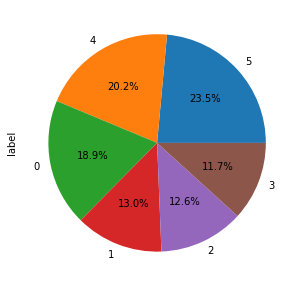

In [ ]:
###CLASS DISTRIBUTION OF THE TRAINING DATA ###
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
df_train['label'].value_counts().plot.pie(autopct = '%1.1f%%')
### Labels ###
# 0 (No reason)
# 1 (Bias and abuse)
# 2 (Jobs and career)
# 3 (Medication)
# 4 (Relationship)
# 5 (Alienation)
print("Label counts for the training data :", df_train['label'].value_counts())

Label counts for the testing data : 5    92
4    91
0    61
2    48
3    43
1    35
Name: label, dtype: Int64


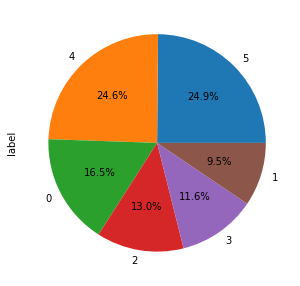

In [ ]:
## CLASS DISTRIBUTION OF TESTING DATA ##
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_test['label'].value_counts().plot.pie(autopct = '%1.1f%%')
print("Label counts for the testing data :", df_test['label'].value_counts())

In [ ]:
from collections import Counter
from imblearn.pipeline import Pipeline, make_pipleline
from sklearn.feature_extraction.text import CounterVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(df_train)

# PREPROCESSING AND CLEANING

In [ ]:
### PREPROCESSING AND CLEANING ###
nltk.download('stopwords')
stops = set(stopwords.words('english'))
print(stops)

{'why', "you're", "it's", 'all', 'wasn', 'do', 'yourself', 'had', 'his', 'hasn', 'isn', 'or', "mightn't", 'being', 'y', 'than', "needn't", 'most', 'very', 've', 'that', 'now', 'o', 'i', 'so', "doesn't", 'doing', 'ourselves', "that'll", 'is', 'me', 'other', 'of', 'some', 'it', "she's", 'nor', 'by', 'those', 'and', 'been', 'after', 'will', 'my', 'who', 're', 'himself', 'against', 'at', 'its', 'both', 'over', 'has', "aren't", 'your', "couldn't", "mustn't", 'there', 'her', 'up', 'aren', "haven't", 'theirs', 'them', 'did', 'doesn', 'few', 'each', 'ma', 'myself', 'mightn', 'here', "hasn't", 'hers', 'no', 'down', 'own', 'what', 'd', "shouldn't", 'with', 'itself', 'this', 'further', "hadn't", "shan't", 'we', "wasn't", 'through', 'the', 'am', 'ours', 'more', 's', 'an', 'him', "you've", 'under', 'couldn', 'above', 'only', 'which', 'about', 'haven', 'they', "won't", 'if', 'don', "weren't", 'shan', 'a', 'll', 'on', 'how', 'weren', 'below', 'hadn', 'between', 'just', 'needn', "wouldn't", 'our', 'he

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def print_plot(df,index):
    example = df[df.index == index+1][['text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('text:', example[1])
# def get_stopwords():
#     try:
#         with open(PATH_STOPWORDS_TR, 'rb') as data_file:
#             return pickle.load(data_file)
#     except IOError as exc:
#         raise IOError("No such stopwords file! Error: " + str(exc))

# def get_blacklist():
#     try:
#         with open(PATH_BLACKLIST_TR, 'rb') as data_file:
#             return pickle.load(data_file)
#     except IOError as exc:
#         raise IOError("No such stopwords file! Error: " + str(exc))

def clean_stopwords(content):
    # content: str
    content = content.split(" ")
    filtered_list = []
    # stopwords = get_stopwords()
    for word in content:
        if word not in stops:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

# def clean_blacklist(content):
#     # content: str
#     # return: str
#     content = content.split(" ")
#     filtered_list = []
#     blacklist = get_blacklist()
#     for word in content:
#         if word not in blacklist:
#             filtered_list.append(word)

#     text = ' '.join(filtered_list)
#     return text

def clean_url(content):
    #  content: str
    #  return: str
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    content = pattern_url.sub('', content)
    return content

def clean_email(content):
    reg_email = '\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    content = pattern_email.sub('', content)
    return content

def clean_punctuation(content):
    # regex = re.compile('[%s]' % re.escape(string.punctuation))
    # content = regex.sub(" ", content)
    content = content.translate(content.maketrans("", "", string.punctuation))
    return content

def clean_numbers(content):
    remove_digits = str.maketrans('', '', string.digits)
    text = content.translate(remove_digits)
    return text

def listToString(text):
    #  text: string
    #  return: string
    str1 = " "
    return (str1.join(text))
  
def clean_postfix(content):
    #  content: list
    #  return: str
    spesific_punctation = [39, 8217]  # ascii codes of spesific punctations
    all_words = defaultdict(list)
    counter = 0
    for i, word in enumerate(content):
        if len(word) > 2:
            if chr(8217) in word:
                replaced_word = word.replace(chr(8217), " ")  # clean for ’
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            elif chr(39) in word:
                replaced_word = word.replace(chr(39), " ")  # clean for '
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            else:
                all_words[i].append(word)
    all_words = sorted(all_words.items())

    text = ""
    for i in range(len(all_words)):
        text = text + " " + all_words[i][1][0]

    return text
  
# def clean_text(content):
#     #  text: string
#     #  return: string
#     content = content.lower()
#     cleaned_email = clean_email(content)
#     cleaned_email_url = clean_url(cleaned_email)
#     cleaned_email_url = listToString(cleaned_email_url.split("."))
#     cleaned_email_url = cleaned_email_url.split(" ")
#     cleaned_email_url_postfix = clean_postfix(cleaned_email_url)
#     cleaned_email_url_postfix_punctuation = clean_punctuation(cleaned_email_url_postfix)
#     cleaned_email_url_postfix_punctuation_numbers = clean_numbers(cleaned_email_url_postfix_punctuation)
#     cleaned_email_url_postfix_punctuation_numbers_stopwords = clean_stopwords(
#         cleaned_email_url_postfix_punctuation_numbers)
#     # cleaned_email_url_postfix_punctuation_numbers_stopwords_blacklist = clean_blacklist(
#         # cleaned_email_url_postfix_punctuation_numbers_stopwords)

#     filtered_sentence = []
#     for word in cleaned_email_url_postfix_punctuation_numbers_stopwords.split(" "):
#         if len(word) > 2:
#             filtered_sentence.append(word)

#     text = ' '.join(filtered_sentence)
#     return text
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
frame = [df_train, df_test]
data = pd.concat(frame)
data


,text,label
0,Hi I don't really know how to phrase this situ...,5
1,i have been so depressed these past couple wee...,1
2,Hi..I don't know where else to go. I am devast...,5
3,"The shit like Ã¢â¬Åit will get better, every...",0
4,I wish I was prettier. I wish I didn't feel li...,1
...,...,...
365,i just don't wanna live anymore so yeah,0
366,I've learned that life is fucking sad sometime...,5
367,That's all. Nothing has gotten better and I've...,5
368,Not the first time I'm going through this of c...,4


In [ ]:
print_plot(df_train, 0)

i have been so depressed these past couple weeks ever since i got back from vacation normal life and reality has hit me and its terrible. im 19 i havent moved out yet i dont really have a sufficient job i have one but its not enough money for me to support myself. at least i have a car and im taking online classes so. i feel stuck in this stupid fucking town. empty and alone man i just want someone to love me dude but im ugly and fat and worthless and no one is ever going to see im worth the chance. its just one thing after another to worry about. why not end it now before i really fuck up and become miserable? i dont see the point in going on im just really down right now i dont know what to do )): all there is darkness idk how to get out of this hole i hate myself i hate my body i hate my life i dont think it will ever get better
text: 1


In [ ]:
### Global variables ###
max_nb_words = 60000
max_features = 10543
maxlen = 500
emb_dim = 100
max_seq_len = 267
batch_size = 32

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
print(df_train['text'][0])

Hi I don't really know how to phrase this situation but I'll try. My life is at a really good point right now, I'm never really depressed over stuff and 99 percent of the time my mind is clear. I'm about to graduate high school and I'm really excited. However, people in my family and friend group have tons of issues. Wether they sleep all day, hate themselves, or have no ambition to keep living on in this world, they've got problems. I don't wanna sound like I'm gloating, but usually I'm the person that a lot of these people end up going to because usually I'm able to talk people through issues and help them in the long run. Yeah sometimes their issues make me really sad and stuff because who doesn't feel sad when people are telling you they feel worthless.

But today one of my best friends showed me that he was cutting and it really effected me. I talked to him about it and it's mostly because of how painfully "bored" he is and he doesn't even know why he's doing it (he's a pretty log

In [ ]:
print(df_train)

                                                   text  label
0     Hi I don't really know how to phrase this situ...      5
1     i have been so depressed these past couple wee...      1
2     Hi..I don't know where else to go. I am devast...      5
3     The shit like Ã¢â¬Åit will get better, every...      0
4     I wish I was prettier. I wish I didn't feel li...      1
...                                                 ...    ...
1456  I think of myself as a spiritual person. I als...      5
1457  Every night it's Ã¢â¬Åyou guys want ice crea...      4
1458  I would like to say that I was shook, but I kn...      3
1459  I can't take this anymore. I've been wanting t...      2
1460  I feel like people are controlling every aspec...      5

[1457 rows x 2 columns]


In [ ]:
print(clean_text(df_train['text'][0]))
text = [clean_text(df_train['text'][0])]

hi dont really know phrase situation ill try life really good point right im never really depressed stuff 99 percent time mind clear im graduate high school im really ecited however people family friend group tons issues wether sleep day hate ambition keep living world theyve got problems dont wanna sound like im gloating usually im person lot people end going usually im able talk people issues help long run yeah sometimes issues make really sad stuff doesnt feel sad people telling feel worthlessbut today one best friends showed cutting really effected talked mostly painfully bored doesnt even know hes hes pretty logical guy go class sit hour time nothing challenging thats way school works clinically diagnosed depression psychiatric ward sees therapist regularly couple hours since showed arm didnt even see ive got two main problems right first dont really know help said literally thing really hang school weekends doesnt sit bed day ive trying make effort much need said long goes highsc

In [ ]:
df_train = df_train.reset_index(drop = True)
df_train['text'] = df_train['text'].apply(clean_text)
print(df_train)

                                                   text  label
0     hi dont really know phrase situation ill try l...      5
1     depressed past couple weeks ever since got bac...      1
2     hii dont know else go devastated right feeling...      5
3     shit like get better everyone purpose need fin...      0
4     wish prettier wish didnt feel like burden wish...      1
...                                                 ...    ...
1452  think spiritual person also think ever belongi...      5
1453  every night guys want ice cream dinner everyon...      4
1454  would like say shook knew habit consuming lot ...      3
1455  cant take anymore ive wanting buy pocket pisto...      2
1456  feel like people controlling every aspect life...      5

[1457 rows x 2 columns]


In [ ]:
y_train = df_train['label']


In [ ]:
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
print(sent_id)

{'input_ids': [[101, 7632, 2123, 2102, 2428, 2113, 7655, 3663, 5665, 3046, 2166, 2428, 2204, 2391, 2157, 10047, 2196, 2428, 14777, 4933, 5585, 3867, 2051, 2568, 3154, 10047, 4619, 2152, 2082, 10047, 2428, 14925, 17572, 2174, 2111, 2155, 2767, 2177, 6197, 3314, 4954, 5886, 3637, 2154, 5223, 16290, 2562, 2542, 2088, 2027, 3726, 2288, 3471, 2123, 2102, 10587, 2614, 2066, 10047, 1043, 4135, 5844, 2788, 10047, 2711, 2843, 2111, 2203, 2183, 2788, 10047, 2583, 2831, 2111, 3314, 2393, 2146, 2448, 3398, 2823, 3314, 2191, 2428, 6517, 4933, 2987, 2102, 2514, 6517, 2111, 4129, 2514, 22692, 8569, 2102, 2651, 2028, 2190, 2814, 3662, 6276, 2428, 3466, 2098, 5720, 3262, 16267, 11471, 2987, 2102, 2130, 2113, 2002, 2015, 2002, 2015, 3492, 11177, 3124, 2175, 2465, 4133, 3178, 2051, 2498, 10368, 2008, 2015, 2126, 2082, 2573, 6612, 2135, 11441, 6245, 13691, 4829, 5927, 19294, 5570, 3232, 2847, 2144, 3662, 2849, 2134, 2102, 2130, 2156, 4921, 2063, 2288, 2048, 2364, 3471, 2157, 2034, 2123, 2102, 2428, 2113, 

# Train Test Validation Split


In [ ]:
print(df_train.shape)
print(df_test.shape)

(1457, 2)
(370, 2)


In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_train['text'], df_train['label'], random_state = 2018, test_size = 0.3, stratify = df_train['label'])
##temp text and temp labels too create a validation and test set ###
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state = 2018, test_size = 0.5, stratify = temp_labels)

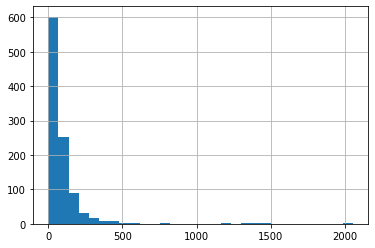

In [ ]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids =False,
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids =False,
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
### Creating Tensors from the train, validation and test sequences ###
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask,val_y)
val_sampler = SequentialSampler(val_data)
valloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
for param in model.parameters():
  param.requires_grad = False

# Defining Model 

In [ ]:
class BERT_Model(nn.Module):
  
  def __init__(self, bert):
    super(BERT_Model, self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768, 512)
    self.fc2= nn.Linear(512, 6)
    self.softmax = nn.Softmax(dim = 1)
  def forward(self, sent_id, mask):
    _, cls_hs = self.bert(sent_id, attention_mask = mask)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.softmax(x)

    return x
    

In [ ]:
input_tensor_id = torch.tensor(sent_id['input_ids'])
input_tensor_mask = torch.tensor(sent_id['attention_mask'])

In [ ]:
print(input_tensor_id.shape)
print(input_tensor_mask.shape)

torch.Size([1, 267])
torch.Size([1, 267])


In [ ]:
m = BERT_Model(model)


In [ ]:
## Verifying if output is 768 ##
out = model(input_tensor_id, input_tensor_mask)
# print(out.last_hidden_state.shape)


In [ ]:
out = out.last_hidden_state
fc = nn.Linear(768, 512)
out = fc(out)
print(out)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(0.1)
out = relu(out)
out = dropout(out)
fc2 = nn.Linear(512, 6)
out = fc2(out)
softmax = torch.nn.Softmax(dim = 1)
out = softmax(out)
print(out.shape)

tensor([[[-0.2618, -0.3090, -0.1609,  ..., -0.1223, -0.6025, -0.4164],
         [-0.4361, -0.2296,  0.1003,  ...,  0.3898, -0.1940, -0.0676],
         [-0.6203, -0.1478, -0.0380,  ..., -0.0294,  0.1356, -0.5093],
         ...,
         [-0.0169,  0.3348, -0.0547,  ...,  0.0029, -0.3441, -0.2892],
         [-0.1927,  0.4461,  0.2751,  ...,  0.3058,  0.1004, -0.3453],
         [-0.2784,  0.2368,  0.0730,  ...,  0.5895, -0.7389,  0.0535]]],
       grad_fn=<ViewBackward0>)
torch.Size([1, 267, 6])


In [ ]:
### Training variables ###
optim = AdamW(m.parameters(), lr = 1e-3)
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)
weights = torch.tensor(weights, dtype = torch.float)
lossfn = nn.NLLLoss(weight=weights)
EPOCHS = 10

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Finetuning BERT

In [ ]:
## Train function ##
def train():
  m.train()
  total_loss, total_accuracy = 0. , 0.
  total_preds = []

  for step, batch in enumerate(trainloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(trainloader)))

    # print(batch)
    sent_id, mask, labels = batch
    m.zero_grad()
    # print(sent_id)
    # print(sent_id.shape)

    # print(type(sent_id))
    # print(mask)
    # print(mask.shape)
    # print(type(mask))
    # print(labels)
    # print(labels.shape)
    preds = m(sent_id, mask)
    # print("preds : ", preds)
    preds = preds.pooler_output
    # print(preds.pooler_output.shape)]
    loss = lossfn(preds, labels)

    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)

    optim.step()

    total_preds.append(preds)

  avg_loss = total_loss / len(trainloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
## Eval function using valloader for evaluating the model ##
def evaluate():
  m.eval()

  total_loss, total_accuracy = 0., 0.

  total_preds = []

  for step, batch in enumerate(valloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valloader)))
    sent_id, mask, labels = batch
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = lossfn(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)
  avg_loss = total_loss / len(valloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
  print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
  #train model
  train_loss, _ = train()
    
  #evaluate model
  valid_loss, _ = evaluate()
    
  #save the best model
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(m.state_dict(), 'saved_weights.pt')
    
  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
    
  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')